In [ ]:
from helpers import *

In [ ]:
import pandas as pd

In [ ]:
data_path = r'D:\HUST\Semesters\2024.2\Vi xử lý\New_\DATA\DATA'
person_name = 'duc' # 'duc' 'duong' 'dung'

df_duc_data = read_log_to_csv(
    data_path=data_path,
    person=person_name,
    color=None,
    date=None,
)

df_duc_data

,pcg,ppg_red,ppg_ir
0,1079,27193.0,25138.0
1,30,27341.0,25177.0
2,-1215,27293.0,25153.0
3,-2347,27127.0,25074.0
4,2944,27130.0,25073.0
...,...,...,...
1981,-503,27593.0,25725.0
1982,-1068,27744.0,25784.0
1983,471,27818.0,25828.0
1984,-1804,27877.0,25846.0


In [4]:
#duc_pcg = df_duc_data_time[['pcg', 'timestamp']].copy()
duc_pcg = df_duc_data['pcg'].copy()

duc_pcg

0       1079
1         30
2      -1215
3      -2347
4       2944
        ... 
1981    -503
1982   -1068
1983     471
1984   -1804
1985   -1426
Name: pcg, Length: 1986, dtype: int64

In [7]:
pcg_minh_anh_path = r'D:\HUST\Semesters\2024.2\Vi xử lý\New_\PCG.TXT'
df_pcg_minh_anh = pd.read_csv(pcg_minh_anh_path, header=None, names=['pcg'])

In [17]:
pd.Series(df_pcg_minh_anh['pcg']).describe()

count     80065
unique     3735
top           0
freq       2478
Name: pcg, dtype: object

In [ ]:
df_pcg_minh_anh_clean = read_clean_pcg_txt(pcg_minh_anh_path)

In [19]:
pd.Series(df_pcg_minh_anh_clean['pcg']).describe()

count    80057.000000
mean       -52.699114
std        425.531749
min      -3511.000000
25%       -103.000000
50%         -9.000000
75%         62.000000
max      11111.000000
Name: pcg, dtype: float64

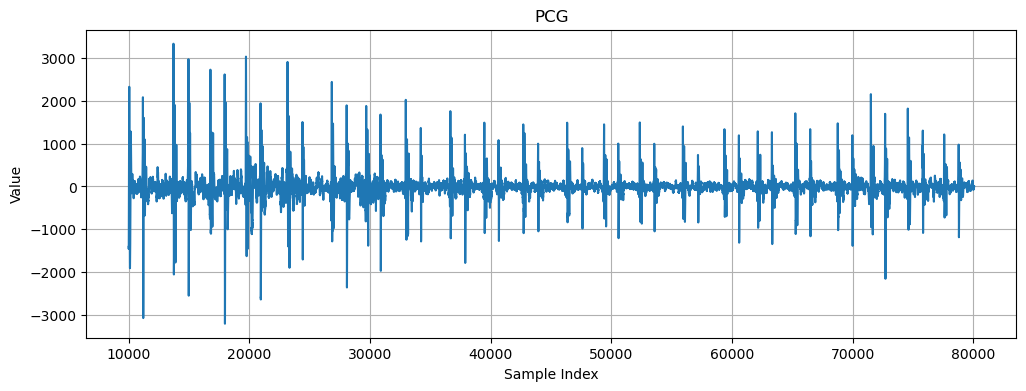

In [48]:
plt.figure(figsize=(12, 4))
plt.plot(df_pcg_minh_anh_clean['pcg'][10000:])
plt.title('PCG')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [47]:
df_pcg_minh_anh_clean['pcg'][10000:]

10000   -1407.0
10001   -1414.0
10002   -1428.0
10003   -1445.0
10004   -1456.0
          ...  
80052      -1.0
80053      -7.0
80054     -11.0
80055      -7.0
80056       0.0
Name: pcg, Length: 70057, dtype: float64

In [58]:
fs = 120
bpm_list, time_stamps = calculate_bpm_per_window(df_pcg_minh_anh_clean['pcg'][10000:].values, fs)

for t, bpm in zip(time_stamps, bpm_list):
    print(f"Time {t:.1f}s → BPM: {bpm:.2f}")


Time 30.0s → BPM: 0.00
Time 90.0s → BPM: 11.34
Time 150.0s → BPM: 0.00
Time 210.0s → BPM: 21.04
Time 270.0s → BPM: 18.39
Time 330.0s → BPM: 15.52
Time 390.0s → BPM: 27.94
Time 450.0s → BPM: 15.62
Time 510.0s → BPM: 12.99


In [22]:
import numpy as np
from scipy.ndimage import uniform_filter1d

def preprocess_signal(signal, normalize=True, smooth = False):
    signal = signal - np.mean(signal)
    # Set lowcut and highcut to valid values for fs=100 (e.g., 1-40 Hz)
    BPF_signal = bandpass_filter(signal, lowcut = 20, highcut = 120, fs=1000)
    normalized_signal = BPF_signal / np.max(np.abs(BPF_signal)) if normalize else BPF_signal
    smoothed_signal = uniform_filter1d(normalized_signal, size=5) if smooth else normalized_signal
    return smoothed_signal

duc_pcg_processed = preprocess_signal(
    signal=duc_pcg, 
    normalize=True, 
    smooth=False)

duc_pcg_processed

array([-0.06308619, -0.19261981, -0.30492877, ...,  0.07040485,
        0.02401285, -0.01469337])

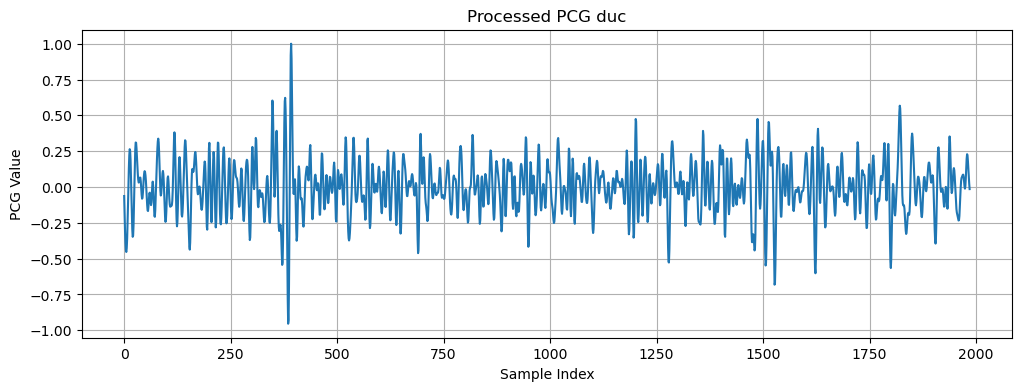

In [23]:
plot_signal(duc_pcg_processed[:], title='Processed')

# DWT PCG

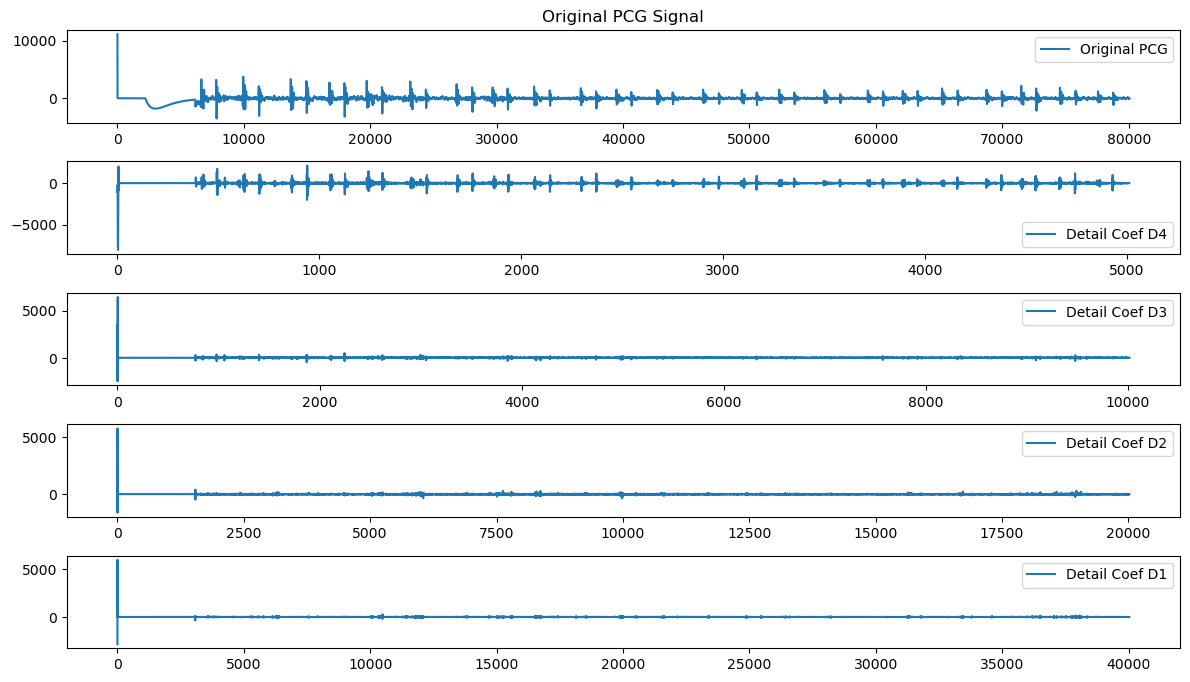

In [28]:
import pywt

# ---- Thực hiện DWT (1-level) ----
wavelet = 'db6'  # Chọn wavelet (thường dùng: 'db4', 'db6', 'sym5')
coeffs = pywt.wavedec(df_pcg_minh_anh_clean['pcg'], wavelet, level=4)

# coeffs = [cA4, cD4, cD3, cD2, cD1]
cA4, cD4, cD3, cD2, cD1 = coeffs

# ---- Vẽ kết quả DWT ----
plt.figure(figsize=(12, 8))
plt.subplot(6, 1, 1)
plt.plot(df_pcg_minh_anh_clean['pcg'], label="Original PCG")
plt.title("Original PCG Signal")
plt.legend()

for i, coef in enumerate(coeffs[1:], 1):  # Chỉ vẽ cD1–cD4
    plt.subplot(6, 1, i+1)
    plt.plot(coef, label=f"Detail Coef D{5-i}")
    plt.legend()

plt.tight_layout()
plt.show()


In [29]:
from scipy.signal import find_peaks

def detect_heart_sounds(detail_coef_d3, distance=30, height=0.2):
    # Tìm các đỉnh lớn trong D3 tương ứng tiếng tim
    peaks, _ = find_peaks(detail_coef_d3, distance=distance, height=height)
    return peaks


In [30]:
def estimate_bpm(peaks, sampling_rate):
    # Tính khoảng cách thời gian giữa các S1
    if len(peaks) < 2:
        return 0  # Không đủ dữ liệu
    intervals = np.diff(peaks) / sampling_rate  # Giây
    avg_rr = np.mean(intervals)
    bpm = 60 / avg_rr
    return bpm


In [31]:
def detect_murmur(detail_coef_d2, peaks_d3, window=50):
    murmur_flags = []
    for i in range(len(peaks_d3) - 1):
        start = peaks_d3[i]
        end = peaks_d3[i+1]
        segment = detail_coef_d2[start+window:end-window]
        energy = np.sum(np.square(segment))
        murmur_flags.append(energy)
    return murmur_flags  # Giá trị lớn → có âm thổi


In [32]:
def reconstruct_clean_signal(coeffs, drop_levels=['cD1', 'cD2']):
    cA4, cD4, cD3, cD2, cD1 = coeffs
    components = {
        'cA4': cA4,
        'cD4': cD4 if 'cD4' not in drop_levels else None,
        'cD3': cD3 if 'cD3' not in drop_levels else None,
        'cD2': cD2 if 'cD2' not in drop_levels else None,
        'cD1': cD1 if 'cD1' not in drop_levels else None,
    }
    clean_signal = pywt.waverec([components['cA4'],
                                 components['cD4'],
                                 components['cD3'],
                                 components['cD2'],
                                 components['cD1']], 'db6')
    return clean_signal


In [33]:
from scipy.stats import entropy, kurtosis, skew

def extract_dwt_features(coeffs):
    features = {}
    for i, c in enumerate(coeffs[1:], 1):  # Bỏ cA
        label = f'D{i}'
        features[f'{label}_energy'] = np.sum(np.square(c))
        features[f'{label}_entropy'] = entropy(np.abs(c) + 1e-12)  # Tránh log(0)
        features[f'{label}_rms'] = np.sqrt(np.mean(c**2))
        features[f'{label}_kurtosis'] = kurtosis(c)
        features[f'{label}_skewness'] = skew(c)
    return features


In [35]:
# 1. DWT
coeffs = pywt.wavedec(df_pcg_minh_anh_clean['pcg'][10000:], 'db6', level=4)
cA4, cD4, cD3, cD2, cD1 = coeffs

# 2. Phát hiện S1/S2
s1_s2_peaks = detect_heart_sounds(cD3)

# 3. Ước tính nhịp tim
bpm = estimate_bpm(s1_s2_peaks, sampling_rate=1000)
print("Estimated BPM:", bpm)

# 4. Phát hiện âm thổi
murmur_scores = detect_murmur(cD2, s1_s2_peaks)

# 5. Tái dựng tín hiệu sạch
clean_signal = reconstruct_clean_signal(coeffs)

# 6. Trích đặc trưng
features = extract_dwt_features(coeffs)

features


Estimated BPM: 1471.2959779993128


{'D1_energy': 122354614.24094436,
 'D1_entropy': 7.4362303336230395,
 'D1_rms': 166.98477149393193,
 'D1_kurtosis': 29.048163308368153,
 'D1_skewness': 0.012410030425209419,
 'D2_energy': 7717600.58975326,
 'D2_entropy': 8.537464573284183,
 'D2_rms': 29.671562458457263,
 'D2_kurtosis': 39.955489508355555,
 'D2_skewness': 0.0034868272883120848,
 'D3_energy': 5959294.898097756,
 'D3_entropy': 9.240780453843444,
 'D3_rms': 18.441897360360503,
 'D3_kurtosis': 48.902761843354305,
 'D3_skewness': -0.2394600228866902,
 'D4_energy': 2306464.6596228713,
 'D4_entropy': 9.851432548219794,
 'D4_rms': 8.113879234973544,
 'D4_kurtosis': 92.08336351213784,
 'D4_skewness': 1.0102321819563715}

In [78]:
s1_s2_peaks, clean_signal, murmur_scores

(array([ 52, 192], dtype=int64),
 array([-0.09051433, -0.10220789, -0.12053511, ...,  0.03433636,
         0.00515888, -0.0084703 ]),
 [4.782847593358344])